# An Introduction to Recurrent Neural Networks

Recurrent neural networks (RNNs) have become increasingly popular in machine learning for handling sequential data. In this tutorial, we will cover [background](#1.-Background) about the architecture, a toy [training example](#2.-Training-a-toy-model), and a demo for [evaluating a larger pre-trained model](#4.-Evaluating-a-pre-trained-model).

**Date**: June 26, 2019

**Authors**: Jennifer Hu (MIT), Ben Huh (IBM), Peng Qian (MIT)

---

## 0. Prerequisites

To run this tutorial, you will need to install [Pytorch](https://pytorch.org/). Just follow the instructions in the docs to install the library and its dependencies. To test your installation, go ahead and run the cell below.

In [1]:
import torch

You will also need [numpy](https://www.numpy.org/), which comes automatically installed with a scientific Python distribution such as [Anaconda](https://www.anaconda.com/). Of course, you can also install it manually. Test your installation by running the cell below.

In [2]:
import numpy as np

## 1. Background: What is an RNN?

Note: The following figures were taken from excellent blog posts by [Christopher Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), [Jianqiang Ma](https://medium.com/@jianqiangma/all-about-recurrent-neural-networks-9e5ae2936f6e), and [Shi Yan](https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714).

In both machine learning and everyday life, many tasks make use of **sequential** data. Take language understanding, for example. As you comprehend each word in this sentence, you draw upon information from the previous words. RNNs have an **inductive bias** for handling this type of data, as parameters are shared across positions in the sequence.

How does this architecture compare to "normal" neural networks? Let $A$ be a neural network, $x_t$ the input, and $h_t$ the output or hidden state vector. Consider the following diagram (credit to [Christopher Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)):

<img src =  "img/rnn_unrolled.png"     style="text-align:center; width: 500px;"/>


The self-loop at $A$ represents the **recurrence** of the network. We can "unroll" it into multiple copies of the same network $A$, sending information down the temporal chain.

## 2. Training a toy RNN

Let's try training our own RNN model.
Here, we implement the model from the following paper (original Tensorflow code [here](https://github.com/gyyang/multitask)):

> "Task representations in neural networks trained to perform many cognitive tasks." Guangyu Robert Yang, Madhura R. Joglekar, H. Francis Song, William T. Newsome & Xiao-Jing Wang (2019). [*Nature Neuroscience* Volume 22, pp. 297–306](https://www.nature.com/articles/s41593-018-0310-2).

This will train a RNN model for 20 types of cognitive tasks. Here's an example: 

<img src =  "img/XJW.png"     style="text-align:center; width: 450px;"/>


We first implement a RNN model. `RNN_multitask/RNN_rate_dynamics.py` is a custom RNN implementation of **continuous-time rate-neuron network dynamics**, which is commonly used in neuroscience models:

$$ \tau \dot{h} = - h + \sigma(W_{hh} h + W_{ih} s) $$

where $x$ is neural (hidden) state,  $s$ is (sensory) input, and $W_{hh}, W_{ih}$ are synaptic weight parameters (recurrent and input weights).

Note that this model uses continuous-time dynamics description, $\dot{h} = f(h(t))$, 
whereas deep-learning models use discrete-time dynamics: $h_{t+1} = f(h_{t})$.

The above dynamics can be simulated via Euler-like integration: 
$$
h_{t+\Delta t} = \gamma h_t + (1 - \gamma) \sigma(W_{hh} h_t + W_{ih} s_t)
$$
where $\gamma = exp(- \Delta t/\tau) \approx 1 - \Delta t/\tau$ is the decay factor, and $\Delta t$ is the discrete timestep,
which is implemented in `RNN_multitask.RNN_rate_dynamics.RNNCell` as

```
activity = self.nonlinearity(input @ self.weight_ih.t() +  hidden @ self.weight_hh.t() + self.bias)
hidden   = self.decay * hidden + (1 - self.decay) * activity
```

Here's a sample code for running the RNN model:

In [3]:
import torch.nn as nn
from RNN_multitask.RNN_rate_dynamics import RNNLayer

T, batch = 1000, 100
n_input, n_rnn, n_output = 10, 500, 5

rnn  = RNNLayer(n_input, n_rnn, nn.ReLU(), 0.9, True)   # input_size, hidden_size, nonlinearity, decay, bias

x       = torch.randn(T, batch, n_input) # input 
hidden0 = torch.zeros(1, batch, n_rnn)   # initial state
output, hidden = rnn(x, hidden0)

The main training code is implemented in the file `RNN_multitask/multitask/train.py`. Below is a sample code for training the model for the 'Mante' task, which trains for mixed motion and color cues:

<img src =  "img/Mante_task.png"     style="text-align:center; width: 350px;"/>

Over time, the cost should go down and performance should go up.

In [4]:
from RNN_multitask import multitask

hp, log, optimizer = multitask.set_hyperparameters(model_dir='debug', hp={'learning_rate': 0.001}, ruleset='mante') #, rich_output=True)
run_model          = multitask.Run_Model(hp, RNNLayer)
multitask.train(run_model, optimizer, hp, log)

Trial       0  | Time 0.00 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.601940| c_reg 0.000000  | perf 0.26
contextdm2     | cost 0.712529| c_reg 0.000000  | perf 0.16
Trial   32000  | Time 50.96 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.213876| c_reg 0.000000  | perf 0.53
contextdm2     | cost 0.220911| c_reg 0.000000  | perf 0.50
Trial   64000  | Time 103.40 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.156858| c_reg 0.000000  | perf 0.66
contextdm2     | cost 0.176406| c_reg 0.000000  | perf 0.59
Trial   96000  | Time 156.09 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.122628| c_reg 0.000000  | perf 0.77
contextdm2     | cost 0.161079| c_reg 0.000000  | perf 0.66
Trial  128000  | Time 208.24 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.110657| c_reg 0.000000  | perf 0.81
contextdm2     | cost 0.118822| c_reg 0.000000  | perf 0.79
Trial  160000  | Time 260.23 s  | Now training c

Finally, let's visualize the results. The analysis functions are in `multitask/standard_analysis.py`

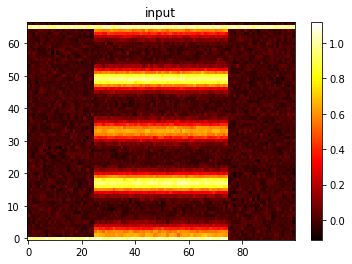

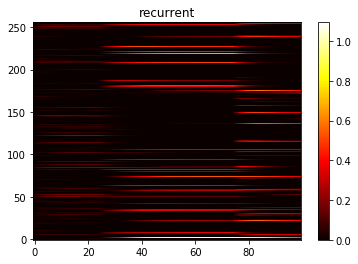

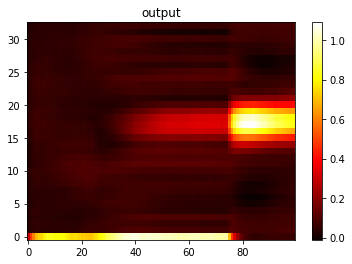

In [5]:
rule = 'contextdm1'
multitask.standard_analysis.easy_activity_plot(run_model, rule)

The RNN model can also be trained for other tasks by simply changing the `ruleset`.

The basic RNN model worked well for this example, but in practice, many applications use a special type of RNN called a **long short-term memory (LSTM)** network. From now on, we'll call non-LSTM RNNs "vanilla RNNs".

## 3. LSTMs: Beyond vanilla RNNs

To motivate the popularity of LSTMs, recall why we were interested in RNNs in the first place: modeling *sequences*. The idea is that items at later parts of a sequence can depend on items at earlier parts of the sequence. The distance between these related items is often called the **dependency length**.

Dependency lengths can be quite short in some cases and quite long in others, even for the same task. Returning to the language example, suppose your task is to predict the last word in a sentence. If your sentence is 

> A car has four *wheels*.

then the gap between the target word (here, "wheels") and the relevant parts of the sequence (here, "car") is relatively small. In contrast, consider the sentence 

> A car can have sentimental value for many owners for a variety of reasons, and can come in many models, sizes, and colors; nevertheless, one defining characteristic of such a machine is that it has four *wheels*.

Here, the gap between "wheels" and "car" is relatively large. Words closer to the end of the sentence such as "machine" and "four" can help guide the prediction of "wheels", but we need the word "car" to nail down the correct word.

In theory, vanilla RNNs are able to capture these dependencies of any length, but in practice, they often fail on long-term dependencies ([Bengio et al. 1994](http://ai.dinfo.unifi.it/paolo//ps/tnn-94-gradient.pdf)). LSTMs ([Hochreiter & Schmidhuber 1997](https://www.mitpressjournals.org/doi/abs/10.1162/neco.1997.9.8.1735)) turn out to be an effective solution to this problem.

### 3.1 LSTM architecture

Consider the following diagram of an LSTM (credit to [Shi Yan](https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714)):

<img src =  "img/lstm.png"     style="text-align:center; width: 550px;"/>


There's a lot going on here, but in short, LSTMs have three multiplicative gates:

1. The **input gate** controls what proportion of the input to pass to the memory cell.
2. The **forget gate** controls what proportion of the previous memory cell information to discard.
3. The **output gate** controls what proportion of the memory cell to output.

## 4. Evaluating a pre-trained model

Now that we've learned how to train a small RNN and have learned about LSTMs, let's examine the behavior of an LSTM that has already been pre-trained on a larger amount of data.

In particular, we will be playing around with a **language model**. A language model assigns a probability distribution over words. It is trained to perform the following task: at each point in a sentence, predict the most probable next word given the preceding context. For example, if the first word of a sentence is "The", then a reasonable language model might assign high probabilities to nouns (e.g. "dog" or "boy") and low probabilities to verbs (e.g. "swims" or "sings") as the next word.

How can we evaluate whether a language model has successfully "learned" English grammar, aside from using our intuition? One thing we can do is test the language model on some basic grammatical phenomena, such as **subject-verb agreement.**

### 4.1 Subject-verb agreement

In English, every well-formed sentence has a **subject** and a **verb**. For example, in the sentence 

> (1) The dog sniffs a bone.

*dog* is the subject, and *sniffs* is the verb. The subject and verb must **agree** in **number** -- that is, a singular subject must be paired with a singular verb, and a plural subject must be paired with a plural verb. Returning to our example, this simply means that

> (1) The dog sniffs a bone.
>
> (2) The dogs sniff a bone.
  
are both grammatically well-formed, but 

> (3) \*The dog sniff a bone.
>
> (4) \*The dogs sniffs a bone.
  
are not. (That's what the asterisk means!)

### 4.2 Evaluation metric

How does this relate to LSTM language models? The key assumption is that a language model that has successfully "learned" English should assign **higher probability** to grammatically well-formed sentences ("grammatical"), and **lower probability** to grammatically ill-formed sentences ("ungrammatical").

This gives us a metric for evaluating our language model. Recall that language models assign probabilities at the level of each word. So a successful model should assign

\begin{align*}
P(\text{singular verb }|\text{ singular subject}) &> P(\text{plural verb }|\text{ singular subject}) \\
P(\text{plural verb }|\text{ plural subject}) &> P(\text{singular verb }|\text{ plural subject}).
\end{align*}

Returning to our example, this means that we would expect

\begin{align*}
P(\text{sniffs }|\text{ The dog}) &> P(\text{sniff }|\text{ The dog}) \\
P(\text{sniff }|\text{ The dogs}) &> P(\text{sniffs }|\text{ The dogs}).
\end{align*}

Finally, for reasons beyond the scope of this tutorial, psycholinguists are typically interested in the **negative log probability** of words, as [it is better correlated with human behavioral measures](https://www.mit.edu/~rplevy/papers/smith-levy-2013-cognition.pdf). Since this quantity is known as **surprisal**, let's denote it by $S$. This means that we will equivalently be looking for the pattern 

\begin{align*}
S(\text{sniffs }|\text{ The dog}) &< S(\text{sniff }|\text{ The dog}) \\
S(\text{sniff }|\text{ The dogs}) &< S(\text{sniffs }|\text{ The dogs}).
\end{align*}

So, does this actually hold in practice? Let's take a look below!

### 4.3 Evaluation

First, let's import some helper functions from `utils.py` that we'll need for evaluation.

In [3]:
import utils

Next, we need to download the parameters for the pre-trained model. This language model has been trained on an Americanized version of the [British National Corpus (BNC)](https://www.english-corpora.org/bnc/). You can **download the model checkpoint** [here](https://www.dropbox.com/s/er9exdbwun4rex9/model_bnc.pt?dl=1). Clicking on the link should download a file called `model_bnc.pt`, which you should move to the `materials` folder.

Once you've done that, let's set some parameters and paths to important information: the model checkpoint, input sentences, and dictionaries containing vocabulary information.

In [4]:
params = {
    'checkpoint': 'materials/model_bnc.pt', # path to model checkpoint
    'eval_data': 'materials/examples.txt', # path to eval data
    'dicts': 'materials/lstm_bnc_dicts.json', # path to dictionaries
    'temperature': 1.0, # higher temperature will increase diversity
    'seed': 1111 # random seed for reproducibility
}

Here, we'll initialize some settings, e.g. random seed and device (CPU or GPU).

In [5]:
torch.manual_seed(params['seed'])
device = torch.device("cpu")
assert(params['temperature'] >= 1e-3)

Load and initialize the model from the specified path.

In [6]:
with open(params['checkpoint'], 'rb') as f:
    model = torch.load(f, map_location=lambda storage, loc: storage)
    model.cpu()
model.eval()

RNNModel(
  (drop): Dropout(p=0.5)
  (encoder): Embedding(68344, 400)
  (rnn): LSTM(400, 400, num_layers=2, dropout=0.5)
  (decoder): Linear(in_features=400, out_features=68344, bias=True)
)

Load the sentences and dictionaries from the specified paths. Note that the sentence file `params['eval_data']` is expected to have one sentence on each line, with tokens separated by spaces. (For the simple sentences that we'll be working with, just think of separating each word with a space, as well as the final period.)

In [15]:
# load eval sentences
with open(params['eval_data'], 'r') as f:
    lines = f.readlines()
sents = [line.strip().split() for line in lines]

# load the dictionaries, word2idx and idx2word, of the preprocessed corpus used by the model
corpus_dict = utils.Dictionary()
corpus_dict.load(params['dicts'])
ntokens = len(corpus_dict)

Now, we need to preprocess the eval data in two ways. First, since there may be words in the eval data that the model has not seen during training, we need to map out-of-vocabulary words to fine-grained `UNK` tokens. Second, we add an `<eos>` token to signify the beginning of the sentence. Otherwise, the model would not be able to assign a probability to the first word, since there is no explicit preceding context.

In [16]:
# map out-of-vocabulary words to "UNK" tokens
sents = [utils.unkify(sent, corpus_dict.word2idx) for sent in sents]

# add <eos> token to beginning of each sentence
for sent in sents:
    sent.insert(0, '<eos>')

Finally, we're ready to perform the evaluation. Each word and its negative log probability will be printed on a new line, separated by a tab (`\t`).

In [17]:
input = torch.randint(ntokens, (1, 1), dtype=torch.long).to(device)

with torch.no_grad():
    for sent in sents:
        # print the sentence
        print('SENTENCE:', ' '.join(sent))
        
        # initialize the hidden layer
        hidden = model.init_hidden(1)

        # map the first word of the sentence to its index in the model vocabulary
        input = torch.tensor([[corpus_dict.word2idx[sent[0]]]],dtype=torch.long).to(device)
        print(sent[0]+'\t'+'--')

        for i, w in enumerate(sent[1:]):
            output, hidden = model(input, hidden)
            word_weights = torch.Tensor.numpy(output.squeeze().div(params['temperature']).exp().cpu())
            total_weight = np.sum(word_weights)
            word_idx = corpus_dict.word2idx[w]
            word_surprisal = -np.log(word_weights[word_idx]/total_weight)
            print(w+'\t'+str(word_surprisal))
            input.fill_(word_idx)
        print()

SENTENCE: <eos> The dog sniffs a bone .
<eos>	--
The	2.4970164
dog	8.273961
sniffs	11.779587
a	2.979677
bone	7.6778884
.	2.6759293

SENTENCE: <eos> The dogs sniff a bone .
<eos>	--
The	2.4970164
dogs	10.054913
sniff	11.877056
a	3.480141
bone	8.105723
.	2.6828048

SENTENCE: <eos> The dog sniff a bone .
<eos>	--
The	2.4970164
dog	8.273961
sniff	13.05693
a	3.4009051
bone	7.726699
.	2.6417565

SENTENCE: <eos> The dogs sniffs a bone .
<eos>	--
The	2.4970164
dogs	10.054913
sniffs	14.093539
a	3.5034008
bone	8.180921
.	2.7263448



We see 

\begin{align*}
S(\text{sniffs }|\text{ $<$eos$>$ The dog}) = 11.78 &< S(\text{sniff }|\text{ $<$eos$>$The dog}) = 13.05 \;\; \checkmark \\
S(\text{sniff }|\text{ $<$eos$>$ The dogs}) = 11.88 &< S(\text{sniffs }|\text{ $<$eos$>$The dogs}) = 14.09 \;\; \checkmark
\end{align*}

as expected. This suggests that the language model has indeed learned something about subject-verb number agreement!

### 4.4 Exploration

Now, it's your turn to play around with the model by designing your own test sentences. You can edit `materials/examples.txt` directly and re-run all the cells after loading the eval data, or make your own file following the format of `materials/examples.txt` and update `params['eval_data']` accordingly. 

Do the results surprise you? What other grammatical phenomena would be good for assessing language models?

(Note: if you're interested in training a language model yourself, see [this Pytorch example](https://github.com/pytorch/examples/tree/master/word_language_model).)

## 5. Useful resources

### 5.1 Further reading

[The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[The Deep Learning textbook](http://www.deeplearningbook.org/) (Chapter 10 is most relevant)

### 5.2 Further practice

[Pytorch character generation tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)

[Pytorch character classification tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)